
# Install Hugging Face Transformers, Datasets, and required ML libraries

In [2]:
!pip install transformers datasets torch scikit-learn seaborn

# Import necessary libraries for data loading, modelling, and evaluation.

In [1]:
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers.optimization import get_linear_schedule_with_warmup

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression



# Check whether the GPU is available.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


Using device: cuda
GPU: Tesla T4


# Load the Yelp Review Full dataset from Hugging Face.

In [6]:
dataset = load_dataset("yelp_review_full")

train_data = dataset["train"]
test_data = dataset["test"]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

yelp_review_full/train-00000-of-00001.pa(…):   0%|          | 0.00/299M [00:00<?, ?B/s]

yelp_review_full/test-00000-of-00001.par(…):   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

# Reduce dataset size for faster training on Colab Pro.

In [7]:
train_data = train_data.shuffle(seed=42).select(range(40000))
test_data = test_data.shuffle(seed=42).select(range(10000))


This cell visualises the distribution of news categories in the AG News dataset. A coloured bar chart is used to clearly show how many samples belong to each class. This analysis helps verify that the dataset is relatively balanced, which is important for training and evaluating classification models fairly.

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_label_distribution(dataset_split):
    """
    Visualises the distribution of class labels in the AG News dataset
    using a coloured Seaborn count plot.
    """

    # Convert labels to pandas Series
    labels = pd.Series(dataset_split["label"])

    # Map numeric labels to category names
    label_map = {
        0: "World",
        1: "Sports",
        2: "Business",
        3: "Sci/Tech"
    }
    labels_named = labels.map(label_map)

    # Plot
    plt.figure(figsize=(8,5))
    sns.countplot(
        x=labels_named,
        order=["World", "Sports", "Business", "Sci/Tech"],
        palette="coolwarm"
    )

    plt.title("Distribution of AG News Articles by Category", fontsize=14)
    plt.xlabel("News Category")
    plt.ylabel("Number of Articles")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


/tmp/ipython-input-1132310451.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


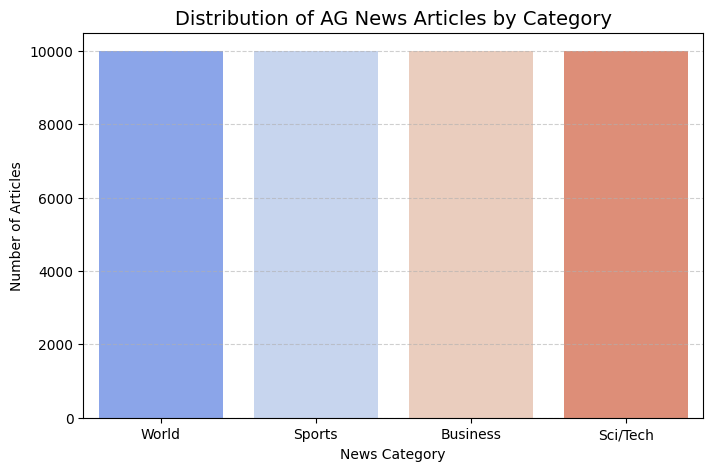

In [13]:
plot_label_distribution(dataset["test"])


This cell performs exploratory data analysis by visualising the distribution of sentiment labels in the dataset. The sentiment categories range from very negative to very positive. This analysis helps assess class balance and provides insight into the overall sentiment composition of the dataset before model training.

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_sentiment_distribution(dataset_split, label_column="label"):
    """
    Plots the distribution of sentiment labels in the dataset using
    a coloured bar chart for exploratory data analysis.
    """

    # Extract labels
    labels = pd.Series(dataset_split[label_column])

    # Map numeric labels to sentiment names
    sentiment_map = {
        0: "Very Negative",
        1: "Negative",
        2: "Neutral",
        3: "Positive",
        4: "Very Positive"
    }
    labels_named = labels.map(sentiment_map)

    # Plot
    plt.figure(figsize=(8,5))
    sns.countplot(
        x=labels_named,
        order=[
            "Very Negative",
            "Negative",
            "Neutral",
            "Positive",
            "Very Positive"
        ],
        palette="coolwarm"
    )

    plt.title("Distribution of Reviews by Sentiment", fontsize=14)
    plt.xlabel("Sentiment")
    plt.ylabel("Number of Reviews")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


/tmp/ipython-input-840613557.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


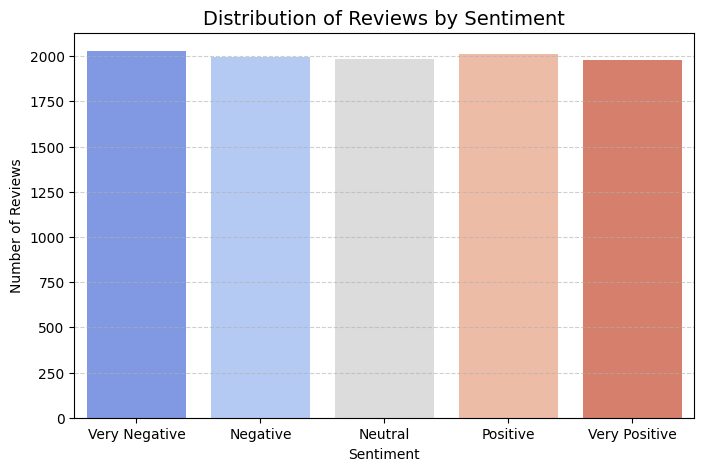

In [15]:
plot_sentiment_distribution(test_data)


/tmp/ipython-input-1468429899.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(bar.get_x() + bar.get_width()/2, yval + total*0.01, f"{yval}\n({percentages[i]:.1f}%)",


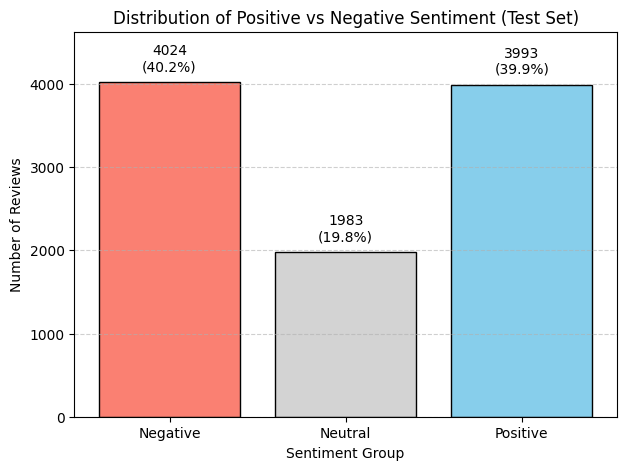

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Map stars to sentiment groups
def sentiment_group(label):
    if label in [0, 1]:
        return "Negative"
    elif label == 2:
        return "Neutral"
    else:
        return "Positive"

# Apply mapping
sentiment_groups = pd.Series(test_data['label']).map(sentiment_group)

# Count per group
group_counts = sentiment_groups.value_counts().reindex(["Negative", "Neutral", "Positive"])
total = group_counts.sum()
percentages = group_counts / total * 100

# Plot
plt.figure(figsize=(7,5))
bars = plt.bar(group_counts.index, group_counts.values, color=['salmon', 'lightgray', 'skyblue'], edgecolor='black')

# Add value labels and percentages on top of bars
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + total*0.01, f"{yval}\n({percentages[i]:.1f}%)",
             ha='center', va='bottom', fontsize=10)

# Titles and labels
plt.ylabel("Number of Reviews")
plt.xlabel("Sentiment Group")
plt.title("Distribution of Positive vs Negative Sentiment (Test Set)")
plt.ylim(0, group_counts.max() * 1.15)  # Add space for labels

# add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# View sample reviews and labels to understand the dataset.

In [ ]:
for i in range(3):
    print("Review:", train_data[i]["text"][:200])
    print("Label:", train_data[i]["label"])
    print()


Review: I stalk this truck.  I've been to industrial parks where I pretend to be a tech worker standing in line, strip mall parking lots, and of course the farmer's market.  The bowls are so so absolutely div
Label: 4

Review: who really knows if this is good pho or not, i was hung tha fuck over and in desperate need of pho therapy. :P but it totally hit the spot and came out super freakin fast!!! omg! aaahhhhh.....\n\ni'm 
Label: 2

Review: I LOVE Bloom Salon... all of their stylist are very qualified and provide excellent hair care...I prefer to book my appointments with Andrea, but if she is not available I am not afraid to book with a
Label: 4



# Load the pre-trained BERT tokeniser for text tokenisation.

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Tokenize text using BERT tokenizer with padding and truncation.

In [ ]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )


# Apply tokenization to train and test datasets.

In [ ]:
tokenized_train = train_data.map(tokenize_function, batched=True)
tokenized_test = test_data.map(tokenize_function, batched=True)


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

# Prepare datasets for PyTorch training.

In [ ]:
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])


# Create DataLoader objects for training and evaluation.

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(tokenized_train, batch_size=16, shuffle=True)
test_loader = DataLoader(tokenized_test, batch_size=16)

# Load the BERT model for multi-class sentiment classification.

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Define an optimiser and a learning rate scheduler for fine-tuning.

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 2
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


# Define a reusable function for training BERT.

In [ ]:
def train_model(model, train_loader, optimizer, scheduler, device):
    model.train()
    train_losses = []

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()

        train_losses.append(loss.item())

    return train_losses


# Define a reusable function for evaluating BERT.

In [ ]:
def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')

    return accuracy, precision, recall, f1, predictions, true_labels


# Fine-tune BERT on Yelp reviews using modular function.

In [ ]:
train_losses_all_epochs = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    train_losses = train_model(model, train_loader, optimizer, scheduler, device)
    train_losses_all_epochs.extend(train_losses)
    print("Last batch loss:", train_losses[-1])


Epoch 1
Last batch loss: 0.9753410816192627
Epoch 2
Last batch loss: 0.8494396209716797


# Plot training loss curve.

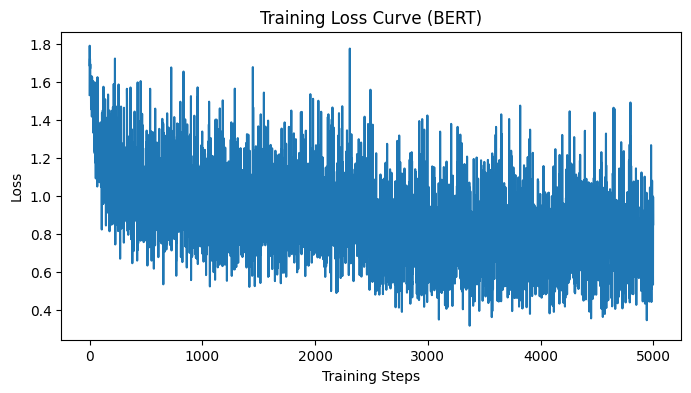

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses_all_epochs)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve (BERT)")
plt.show()


# Evaluate fine-tuned BERT model.

In [ ]:
accuracy, precision, recall, f1, predictions, true_labels = evaluate_model(model, test_loader, device)

print("BERT Results")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


BERT Results
Accuracy: 0.6119
Precision: 0.6084045179728722
Recall: 0.6116121661617642
F1-score: 0.609711886264195


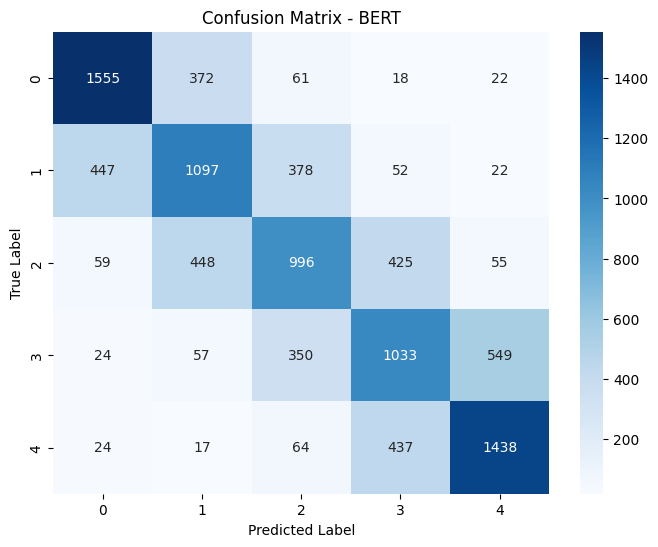

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - BERT")
plt.show()

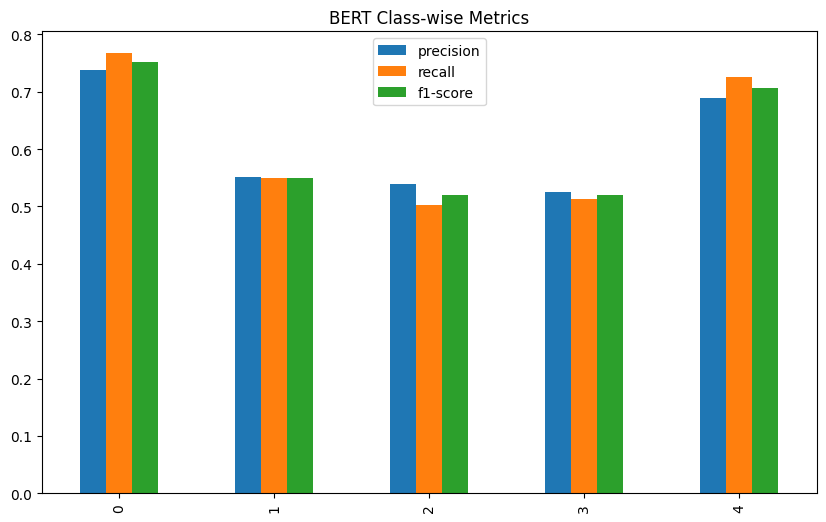

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(true_labels, predictions, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report[['precision','recall','f1-score']].iloc[:-3].plot(kind='bar', figsize=(10,6))
plt.title("BERT Class-wise Metrics")
plt.show()


# Train TF-IDF + Logistic Regression baseline model.

This cell implements a traditional machine learning baseline using TF-IDF features and Logistic Regression. The text data is converted into numerical vectors using TF-IDF, which captures the importance of words across documents. Logistic Regression is then trained on these features to perform text classification. This baseline serves as a performance reference for comparing against the fine-tuned BERT model.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def train_tfidf_logistic_baseline(train_data, test_data, max_features=10000):
    """
    Trains and evaluates a TF-IDF + Logistic Regression baseline model.

    This baseline provides a traditional machine learning comparison
    against the fine-tuned BERT model.
    """

    # Extract text and labels
    X_train = train_data["text"]
    y_train = train_data["label"]
    X_test = test_data["text"]
    y_test = test_data["label"]

    # TF-IDF vectorisation
    vectorizer = TfidfVectorizer(max_features=max_features)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Logistic Regression classifier
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_tfidf, y_train)

    # Predictions
    preds = model.predict(X_test_tfidf)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, preds, average="macro"
    )

    # Print results
    print("Baseline TF-IDF + Logistic Regression Results")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")

    return model, vectorizer, {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [17]:
baseline_model, tfidf_vectorizer, baseline_metrics = train_tfidf_logistic_baseline(
    train_data, test_data
)


Baseline TF-IDF + Logistic Regression Results
Accuracy : 0.5651
Precision: 0.5611
Recall   : 0.5647
F1-score : 0.5626


# Evaluate baseline model.

This cell visualises the confusion matrix for the baseline TF-IDF and Logistic Regression model. The confusion matrix shows how often each news category is correctly classified and where misclassifications occur. This provides a more detailed evaluation of the baseline model’s performance beyond overall accuracy.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_baseline_confusion_matrix(y_true, y_pred, class_names=None):
    """
    Plots a confusion matrix for the baseline TF-IDF + Logistic Regression model.

    Parameters
    ----------
    y_true : array-like
        Ground-truth labels.
    y_pred : array-like
        Predicted labels from the baseline model.
    class_names : list, optional
        List of class names for axis labels.
    """

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Default class names if none provided
    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Oranges",
        xticklabels=class_names,
        yticklabels=class_names
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix – Baseline Logistic Regression")
    plt.tight_layout()
    plt.show()


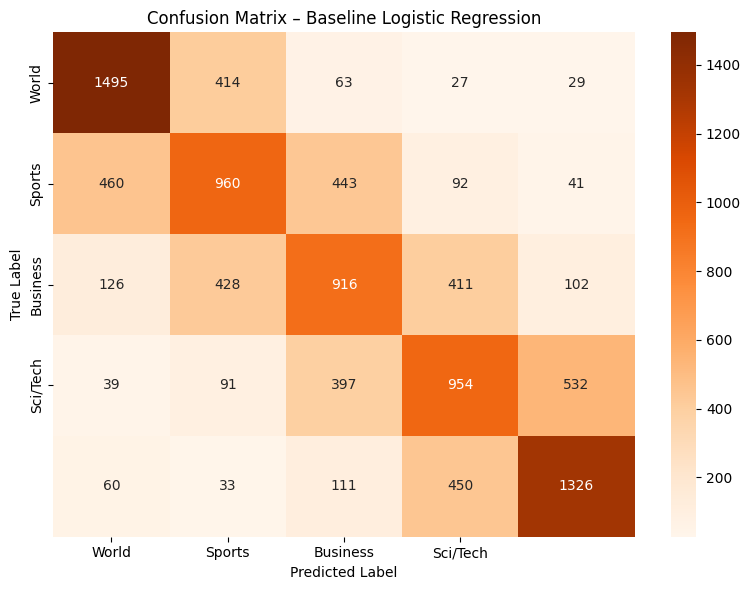

In [20]:
class_names = ["World", "Sports", "Business", "Sci/Tech"]

# Re-extract y_test from test_data
y_test = test_data["label"]

# Transform the test data using the trained TF-IDF vectorizer
X_test_tfidf = tfidf_vectorizer.transform(test_data["text"])

# Get predictions from the trained baseline model
baseline_preds = baseline_model.predict(X_test_tfidf)

plot_baseline_confusion_matrix(y_test, baseline_preds, class_names)

# Compare BERT and baseline performance.

This cell compares the performance of the fine-tuned BERT model and the TF-IDF Logistic Regression baseline using standard evaluation metrics. The bar chart provides a clear visual comparison of accuracy, precision, recall, and F1-score, highlighting the performance improvements achieved by the BERT model.

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_model_performance_comparison(bert_metrics, baseline_metrics):
    """
    Plots a side-by-side comparison of evaluation metrics
    between the BERT model and the baseline model.

    Parameters
    ----------
    bert_metrics : dict
        Dictionary containing accuracy, precision, recall and F1-score for BERT.
    baseline_metrics : dict
        Dictionary containing accuracy, precision, recall and F1-score for the baseline.
    """

    metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
    bert_scores = [
        bert_metrics["accuracy"],
        bert_metrics["precision"],
        bert_metrics["recall"],
        bert_metrics["f1"]
    ]
    baseline_scores = [
        baseline_metrics["accuracy"],
        baseline_metrics["precision"],
        baseline_metrics["recall"],
        baseline_metrics["f1"]
    ]

    x = np.arange(len(metrics))
    width = 0.35

    plt.figure(figsize=(8,5))
    plt.bar(x - width/2, bert_scores, width, label="BERT")
    plt.bar(x + width/2, baseline_scores, width, label="Baseline")

    plt.xticks(x, metrics)
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.title("Model Performance Comparison")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


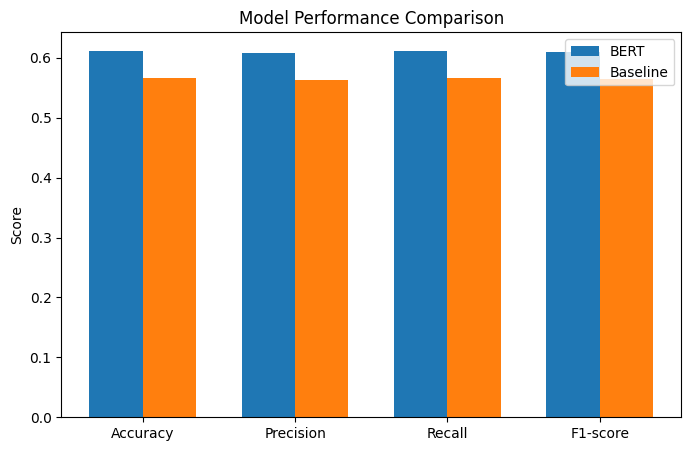

In [ ]:
plot_model_performance_comparison(bert_metrics, baseline_metrics)


# Compare only the accuracy of BERT vs Baseline.

This cell visualises the accuracy comparison between the TF-IDF + Logistic Regression baseline and the fine-tuned BERT model. A bar chart with value labels provides a clear and immediate view of performance improvement achieved by BERT over the baseline.

In [24]:
import matplotlib.pyplot as plt

def plot_accuracy_comparison(models, scores, colors=None):
    """
    Plots a bar chart comparing model accuracies.

    Parameters
    ----------
    models : list of str
        Names of the models to compare.
    scores : list of float
        Accuracy scores corresponding to each model.
    colors : list of str, optional
        Colors for each bar. Defaults to ['skyblue', 'salmon', ...] if not provided.
    """
    if colors is None:
        colors = plt.cm.Set2.colors[:len(models)]  # default color palette

    plt.figure(figsize=(6,4))
    bars = plt.bar(models, scores, color=colors)
    plt.ylim(0, 1)
    plt.ylabel("Accuracy")
    plt.title("Accuracy Comparison: Models")

    # Add value labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.3f}",
                 ha='center', va='bottom', fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


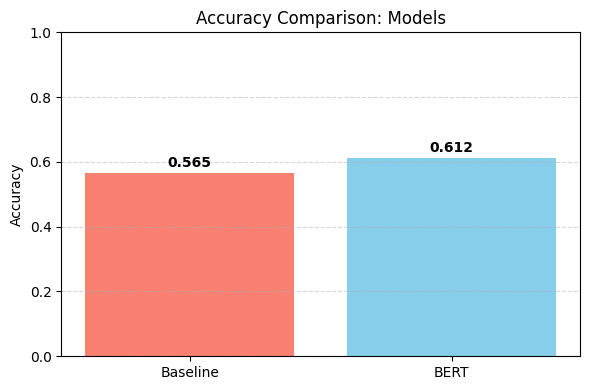

In [26]:
models = ["Baseline", "BERT"]
accuracy_scores = [0.5651, 0.6119]  # updated with actual results
colors = ['salmon', 'skyblue']

plot_accuracy_comparison(models, accuracy_scores, colors)

